In [29]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import math
from scipy.optimize import minimize_scalar
import pandas as pd
import os

In [30]:
# Define parameters
eps, theta, eta, lam = sp.symbols('eps theta eta lam', real=True)

Derive H(X|Y) as a fucntion of error rate

In [31]:
# Calculate the constant H(X|Y) given epsilon
h_XY = -eps * sp.log(eps, 2) - (1 - eps) * sp.log(1 - eps, 2)

h_XY

-eps*log(eps)/log(2) - (1 - eps)*log(1 - eps)/log(2)

Derive H(X|Z) as a function of Theta

In [32]:
# Define density matrices of Eve obtained from partial tracing the joint state of Bob and Eve after Cloning Machine

rho_0 = (1/2) * sp.Matrix([
    [1 + sp.sin(eta)**2, sp.cos(eta)],
    [sp.cos(eta), sp.cos(eta)**2]
])
rho_1 = (1/2) * sp.Matrix([
    [1 + sp.sin(eta)**2, sp.exp(-sp.I * theta) * sp.cos(eta)],
    [sp.exp(sp.I * theta) * sp.cos(eta), sp.cos(eta)**2]
])

# Compute eigenvalues for each density matrix
ev0 = list(rho_0.eigenvals().keys())
ev1 = list(rho_1.eigenvals().keys())

# Verify sum of eigenvalues is 1
for i, ev in enumerate(ev0):
    print(f"Eigenvalue {i + 1} simplified : {ev} ")
sum_eigenval0 = sum(ev0)
print(f"Sum of the eigenvalues: {sum_eigenval0}")
for i, ev in enumerate(ev1):
    print(f"Eigenvalue {i + 1} simplified : {ev} ")
sum_eigenval1 = sum(ev1)
print(f"Sum of the eigenvalues: {sum_eigenval1}")

Eigenvalue 1 simplified : 0.5 - 0.467707173346743*sqrt(0.142857142857143*cos(4*eta) + 1.0) 
Eigenvalue 2 simplified : 0.467707173346743*sqrt(0.142857142857143*cos(4*eta) + 1.0) + 0.5 
Sum of the eigenvalues: 1.00000000000000
Eigenvalue 1 simplified : 0.5 - 0.467707173346743*sqrt(0.142857142857143*cos(4*eta) + 1.0) 
Eigenvalue 2 simplified : 0.467707173346743*sqrt(0.142857142857143*cos(4*eta) + 1.0) + 0.5 
Sum of the eigenvalues: 1.00000000000000


In [33]:
# Define density matrix of Eve where rho_e = 1/2 (rho_0 + rho_1)
rho_e = 0.25 * sp.Matrix([
    [2 + 2 * sp.sin(eta)**2, sp.cos(eta) + (sp.cos(theta) - sp.I * sp.sin(theta)) * sp.cos(eta)],
    [sp.cos(eta) + (sp.cos(theta) + sp.I * sp.sin(theta)) * sp.cos(eta), 2 * sp.cos(eta)**2] 
])

# Compute eigenvalues of Eve's density matrices
eigenval_ = list(rho_e.eigenvals().keys())
eigenval = [ev.simplify() for ev in eigenval_]

# Verify sum of eigenvalues is 1
for i, ev in enumerate(eigenval):
    print(f"Eigenvalue {i + 1} simplified : {ev} ")
sum_eigenval = sum(eigenval_)
print(f"Sum of the eigenvalues: {sum_eigenval}")

Eigenvalue 1 simplified : 0.5 - sqrt(-(1.0*sin(eta)**2 - 0.5*cos(theta) + 0.5)*cos(eta)**2 + 1.0)/2 
Eigenvalue 2 simplified : sqrt(-(1.0*sin(eta)**2 - 0.5*cos(theta) + 0.5)*cos(eta)**2 + 1.0)/2 + 0.5 
Sum of the eigenvalues: 1.00000000000000


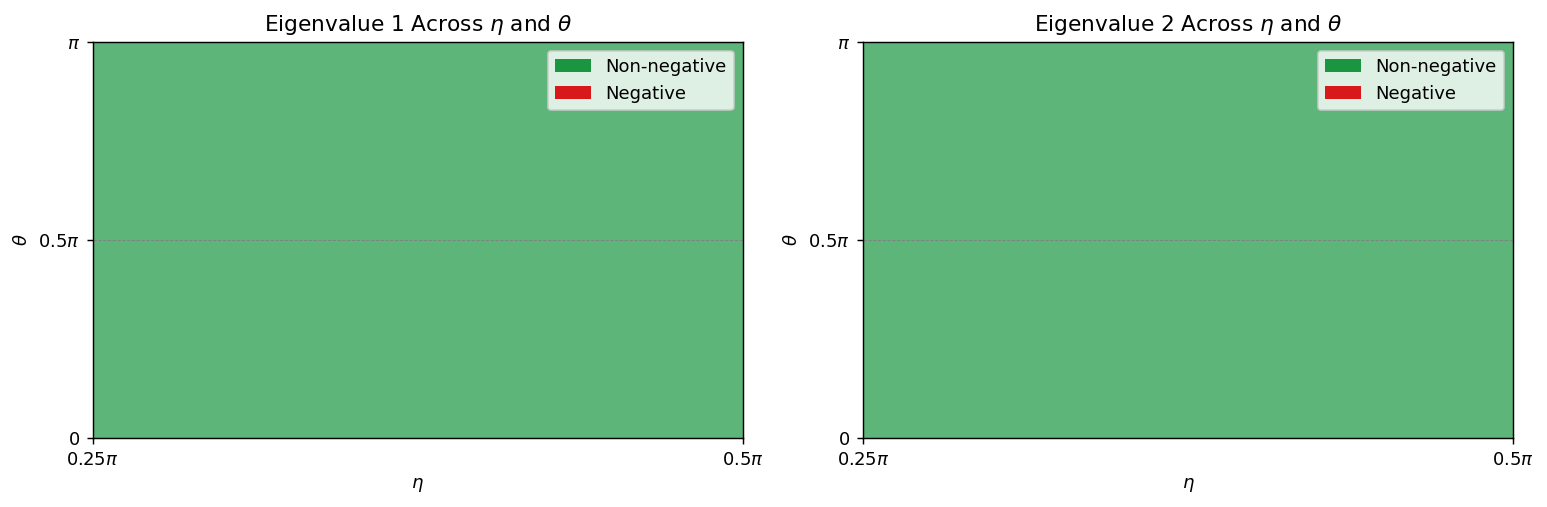

In [34]:
#Check eigenvalues non-negativity

# Set ranges for eta and theta and set binary arrays indicating non-negativity
eta_vals = np.linspace(np.pi/4, np.pi/2, 200)
theta_vals = np.linspace(0, np.pi, 200)
ei1 = sp.lambdify((eta, theta), eigenval[0], 'numpy') # Select from {ev0, ev1, eigenval} and check for non-negativity
ei2 = sp.lambdify((eta, theta), eigenval[1], 'numpy') # Similarly, select from {ev0, ev1, eigenval}
eta_mesh, theta_mesh = np.meshgrid(eta_vals, theta_vals)
eigenval1_vals = ei1(eta_mesh, theta_mesh)
eigenval2_vals = ei2(eta_mesh, theta_mesh)
eigenval1_binary = np.where(eigenval1_vals >= 0, 1, 0)
eigenval2_binary = np.where(eigenval2_vals >= 0, 1, 0)

legend_elements = [
    Patch(facecolor='#1a9641', label='Non-negative'),
    Patch(facecolor='#d7191c', label='Negative')
]

def plot_eigenvalue(ax, binary_vals, title):
    contour = ax.contourf(eta_vals, theta_vals, binary_vals, levels=[-0.5, 0.5, 1.5], colors=['#d7191c', '#1a9641'], 
                          alpha=0.7)
    ax.set_xticks([np.pi/4, np.pi/2])
    ax.set_xticklabels([r'$0.25\pi$', r'$0.5\pi$'])
    ax.set_yticks([0, np.pi/2, np.pi])
    ax.set_yticklabels([r'$0$', r'$0.5\pi$', r'$\pi$'])
    ax.set_xlabel(r'$\eta$')
    ax.set_ylabel(r'$\theta$')
    ax.set_title(title)
    ax.grid(visible=True, color='gray', linestyle='--', linewidth=0.5)
    ax.legend(handles=legend_elements, loc='upper right')

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=130)
plot_eigenvalue(axes[0], eigenval1_binary, r'Eigenvalue 1 Across $\eta$ and $\theta$')
plot_eigenvalue(axes[1], eigenval2_binary, r'Eigenvalue 2 Across $\eta$ and $\theta$')
plt.tight_layout()
plt.show()

In [35]:
# Compute the Von Neumann Entropy for rho_ae and rho_e
S_ae = 0.5 * (-sum(ev * sp.log(ev, 2) for ev in ev0) + -sum(ev * sp.log(ev, 2) for ev in ev1)) + 1
S_e = -sum(ev * sp.log(ev, 2) for ev in eigenval)

In [36]:
# Compute H(X|Z)
_h_XZ = S_ae - S_e
s_h_XZ = sp.simplify(_h_XZ)

# Asuuming Bob's measurement error all come from cloning machine, Fidelity_b = 1 - eps
sub_h_XZ = s_h_XZ.subs({eta: sp.asin(1 - 2 * eps)})
h_XZ = sp.simplify(sub_h_XZ)

h_XZ

(-(sqrt(((2*eps - 1)**2 - 1)*(4.0*eps**2 - 4.0*eps - 0.5*cos(theta) + 1.5) + 1.0) - 1.0)*log(0.5 - sqrt(((2*eps - 1)**2 - 1)*(4.0*eps**2 - 4.0*eps - 0.5*cos(theta) + 1.5) + 1.0)/2) + (sqrt(((2*eps - 1)**2 - 1)*(4.0*eps**2 - 4.0*eps - 0.5*cos(theta) + 1.5) + 1.0) + 1.0)*log(sqrt(((2*eps - 1)**2 - 1)*(4.0*eps**2 - 4.0*eps - 0.5*cos(theta) + 1.5) + 1.0)/2 + 0.5) + 2*(2.82842712474619*sqrt(0.5*eps**4 - eps**3 + 0.625*eps**2 - 0.125*eps + 0.03125) - 0.5)*log(0.5 - 2.82842712474619*sqrt(0.5*eps**4 - eps**3 + 0.625*eps**2 - 0.125*eps + 0.03125)) - 2.0*(2.82842712474619*sqrt(0.5*eps**4 - eps**3 + 0.625*eps**2 - 0.125*eps + 0.03125) + 0.5)*log(2.82842712474619*sqrt(0.5*eps**4 - eps**3 + 0.625*eps**2 - 0.125*eps + 0.03125) + 0.5) + log(4))/(2*log(2))

Plot H(X|Z) graph

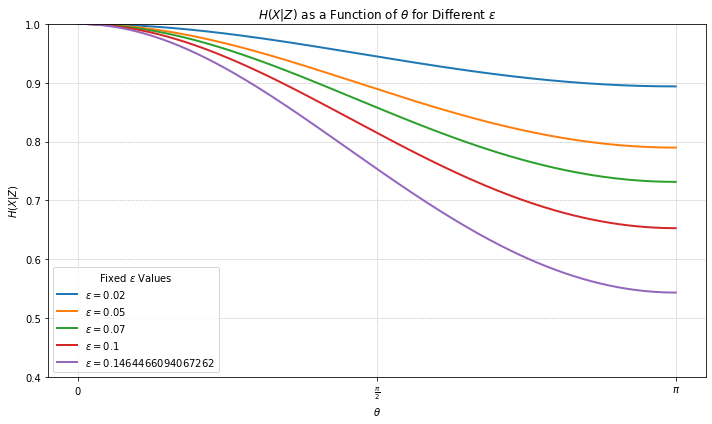

In [37]:
# Plot H(X|Z) against Theta

h_XZ_func = sp.lambdify((eps, theta), h_XZ, 'numpy')

# Set up ranges for epsilon and theta
eps_vals = np.linspace(0, (2 - math.sqrt(2)) / 4, 200)
theta_vals = np.linspace(0, np.pi, 200)

plt.figure(figsize=(10, 6))

for eps_val in [0.02, 0.05, 0.07, 0.1, (2 - math.sqrt(2)) / 4]:
    h_XZ_vals = h_XZ_func(eps_val, theta_vals)
    plt.plot(theta_vals, h_XZ_vals, label=f'$\\epsilon = {eps_val}$', lw=2)

plt.ylim(0.4, 1)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$H(X|Z)$')
plt.title(r'$H(X|Z)$ as a Function of $\theta$ for Different $\epsilon$')
plt.xticks([0, np.pi / 2, np.pi],
           [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.legend(title="Fixed $\epsilon$ Values")
plt.tight_layout()
plt.show()

Derive R as a function of theta and error rate

In [38]:
# Find the proportion of usable rounds from key disrtribution phase (form raw key)
f_distibute = 1/4 * (1 - sp.cos(theta))

f_distibute

0.25 - 0.25*cos(theta)

In [39]:
# Find the proportion of which the raw key can be shrunk
_f_rawkey = h_XZ - h_XY
f_rawkey = sp.simplify(_f_rawkey)

f_rawkey

(eps*log(eps) - (eps - 1)*log(1 - eps) - (sqrt(((2*eps - 1)**2 - 1)*(4.0*eps**2 - 4.0*eps - 0.5*cos(theta) + 1.5) + 1.0) - 1.0)*log(0.5 - sqrt(((2*eps - 1)**2 - 1)*(4.0*eps**2 - 4.0*eps - 0.5*cos(theta) + 1.5) + 1.0)/2)/2 + (sqrt(((2*eps - 1)**2 - 1)*(4.0*eps**2 - 4.0*eps - 0.5*cos(theta) + 1.5) + 1.0) + 1.0)*log(sqrt(((2*eps - 1)**2 - 1)*(4.0*eps**2 - 4.0*eps - 0.5*cos(theta) + 1.5) + 1.0)/2 + 0.5)/2 + (2.82842712474619*sqrt(0.5*eps**4 - eps**3 + 0.625*eps**2 - 0.125*eps + 0.03125) - 0.5)*log(0.5 - 2.82842712474619*sqrt(0.5*eps**4 - eps**3 + 0.625*eps**2 - 0.125*eps + 0.03125)) - 1.0*(2.82842712474619*sqrt(0.5*eps**4 - eps**3 + 0.625*eps**2 - 0.125*eps + 0.03125) + 0.5)*log(2.82842712474619*sqrt(0.5*eps**4 - eps**3 + 0.625*eps**2 - 0.125*eps + 0.03125) + 0.5) + log(4)/2)/log(2)

In [40]:
# Key generating rate R = proportion of raw key formed from distributed bits x proportion of raw key retained
_R = f_distibute * f_rawkey
R = sp.simplify(_R)

R

-0.125*(cos(theta) - 1)*(2*eps*log(eps) - 2*(eps - 1)*log(1 - eps) - (sqrt(((2*eps - 1)**2 - 1)*(4.0*eps**2 - 4.0*eps - 0.5*cos(theta) + 1.5) + 1.0) - 1.0)*log(0.5 - sqrt(((2*eps - 1)**2 - 1)*(4.0*eps**2 - 4.0*eps - 0.5*cos(theta) + 1.5) + 1.0)/2) + (sqrt(((2*eps - 1)**2 - 1)*(4.0*eps**2 - 4.0*eps - 0.5*cos(theta) + 1.5) + 1.0) + 1.0)*log(sqrt(((2*eps - 1)**2 - 1)*(4.0*eps**2 - 4.0*eps - 0.5*cos(theta) + 1.5) + 1.0)/2 + 0.5) + 2*(2.82842712474619*sqrt(0.5*eps**4 - eps**3 + 0.625*eps**2 - 0.125*eps + 0.03125) - 0.5)*log(0.5 - 2.82842712474619*sqrt(0.5*eps**4 - eps**3 + 0.625*eps**2 - 0.125*eps + 0.03125)) - 2.0*(2.82842712474619*sqrt(0.5*eps**4 - eps**3 + 0.625*eps**2 - 0.125*eps + 0.03125) + 0.5)*log(2.82842712474619*sqrt(0.5*eps**4 - eps**3 + 0.625*eps**2 - 0.125*eps + 0.03125) + 0.5) + log(4))/log(2)

Plot R graphs

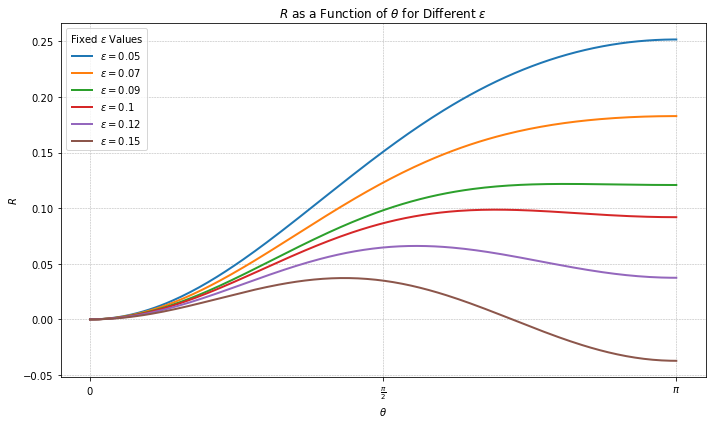

In [41]:
# Plot R against Theta for different values of Eps

R_func = sp.lambdify((theta, eps), R, 'numpy') 
theta_vals = np.linspace(0, np.pi - 1e-6, 200)

plt.figure(figsize=(10, 6))

for eps_val in [0.05, 0.07, 0.09, 0.1, 0.12, 0.15]: 
    R_vals = R_func(theta_vals, eps_val)
    plt.plot(theta_vals, R_vals, label=f'$\\epsilon = {eps_val}$', lw=2)

plt.xlabel(r'$\theta$')
plt.ylabel(r'$R$')
plt.title(r'$R$ as a Function of $\theta$ for Different $\epsilon$')
plt.xticks([0, np.pi / 2, np.pi],
           [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.legend(title="Fixed $\epsilon$ Values")
plt.tight_layout()
plt.show()

<lambdifygenerated-30>:2: RuntimeWarning: divide by zero encountered in log
  return -0.125*(cos(theta) - 1)*(2*eps*log(eps) - 2*(eps - 1)*log(1 - eps) - (sqrt(((2*eps - 1)**2 - 1)*(4.0*eps**2 - 4.0*eps - 0.5*cos(theta) + 1.5) + 1.0) - 1.0)*log(0.5 - 1/2*sqrt(((2*eps - 1)**2 - 1)*(4.0*eps**2 - 4.0*eps - 0.5*cos(theta) + 1.5) + 1.0)) + (sqrt(((2*eps - 1)**2 - 1)*(4.0*eps**2 - 4.0*eps - 0.5*cos(theta) + 1.5) + 1.0) + 1.0)*log((1/2)*sqrt(((2*eps - 1)**2 - 1)*(4.0*eps**2 - 4.0*eps - 0.5*cos(theta) + 1.5) + 1.0) + 0.5) + 2*(2.82842712474619*sqrt(0.5*eps**4 - eps**3 + 0.625*eps**2 - 0.125*eps + 0.03125) - 0.5)*log(0.5 - 2.82842712474619*sqrt(0.5*eps**4 - eps**3 + 0.625*eps**2 - 0.125*eps + 0.03125)) - 2.0*(2.82842712474619*sqrt(0.5*eps**4 - eps**3 + 0.625*eps**2 - 0.125*eps + 0.03125) + 0.5)*log(2.82842712474619*sqrt(0.5*eps**4 - eps**3 + 0.625*eps**2 - 0.125*eps + 0.03125) + 0.5) + log(4))/log(2)
<lambdifygenerated-30>:2: RuntimeWarning: invalid value encountered in multiply
  return -0.125

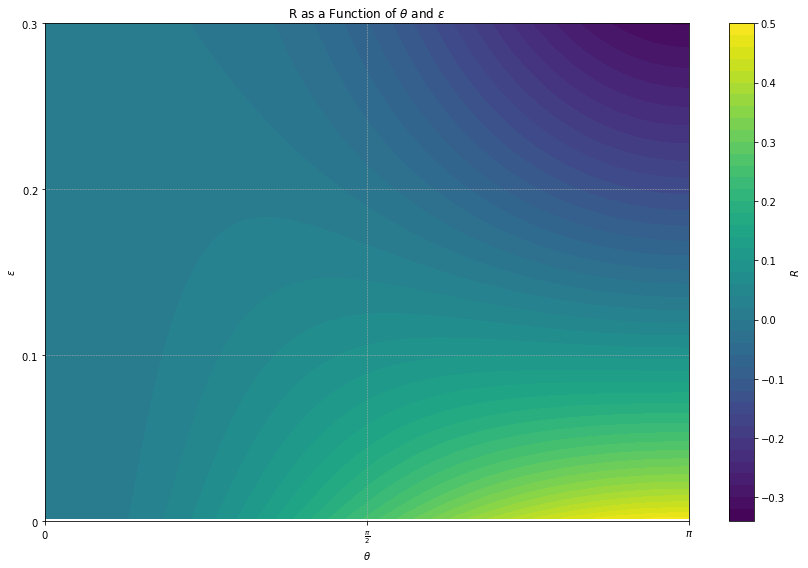

In [59]:
# Plot R agaisnt Theta and Eps
R_func = sp.lambdify((eps, theta), R, 'numpy')

# Set up ranges for epsilon and theta
eps_vals = np.linspace(0, 0.3, 200)
theta_vals = np.linspace(0, np.pi, 200)
eps_mesh, theta_mesh = np.meshgrid(eps_vals, theta_vals)

R_vals = R_func(eps_mesh, theta_mesh)

plt.figure(figsize=(12, 8))
contour = plt.contourf(theta_mesh, eps_mesh, R_vals, levels=50, cmap="viridis")
plt.colorbar(contour, label=r'$R$')

plt.xlabel(r'$\theta$')
plt.ylabel(r'$\epsilon$')
plt.title(r'R as a Function of $\theta$ and $\epsilon$')
plt.xticks([0, np.pi / 2, np.pi],
           [r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
plt.yticks([0, 0.1, 0.2, 0.3],
           [r'$0$', r'$0.1$', r'$0.2$', r'$0.3$'])
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Solve for optimal Theta that maximises R

In [43]:
# Find optimal Theta

R_func = sp.lambdify((eps, theta), R, 'numpy')

def find_optimal_theta(eps_val):
    def neg_R(theta):
        return -R_func(eps_val, theta)

    result = minimize_scalar(neg_R, bounds=(0, np.pi), method="bounded")

    optimal_theta = result.x
    return optimal_theta

eps_val = 0.1
optimal_theta = find_optimal_theta(eps_val)
print(f"Optimal theta for epsilon = {eps_val}: {optimal_theta}")

f_R = R.subs({eps: eps_val, theta: optimal_theta})
R_value = f_R.evalf()
print(f"Corresponding R = {R_value}")

Optimal theta for epsilon = 0.1: 2.1740114228617635
Corresponding R = 0.0986465126643173


Find critical error rate (bound on R = 0.05)

In [45]:
# Find critical error rate
def find_critical_eps_binary(eps_start=0.01, eps_end=0.5, tol=1e-6):
    eps_low = eps_start
    eps_high = eps_end

    while eps_high - eps_low > tol:
        eps_mid = (eps_low + eps_high) / 2

        cur_theta = find_optimal_theta(eps_mid)
        R_value = R_func(eps_mid, cur_theta)

        if R_value < 0.05:
            eps_high = eps_mid
        else:
            eps_low = eps_mid

    critical_eps = (eps_low + eps_high) / 2
    final_theta = find_optimal_theta(critical_eps)
    final_R = R_func(critical_eps, final_theta)

    return critical_eps, final_R

eps_critical, R_critical = find_critical_eps_binary(eps_start=0.01, eps_end=0.5)

print(f"critical epsilon = {eps_critical}")
print(f"R = {R_critical}")


critical epsilon = 0.1343827533721924
R = 0.04999984870111445


Analysis and Plots

In [46]:
# Find max R
min_eps = 1e-6 # 0.000001
max_theta = find_optimal_theta(min_eps)
max_R = R.subs({eps: min_eps, theta: max_theta})
max_R_value = max_R.evalf()

print(f"Max R: {max_R_value}")

Max R: 0.499979625715123


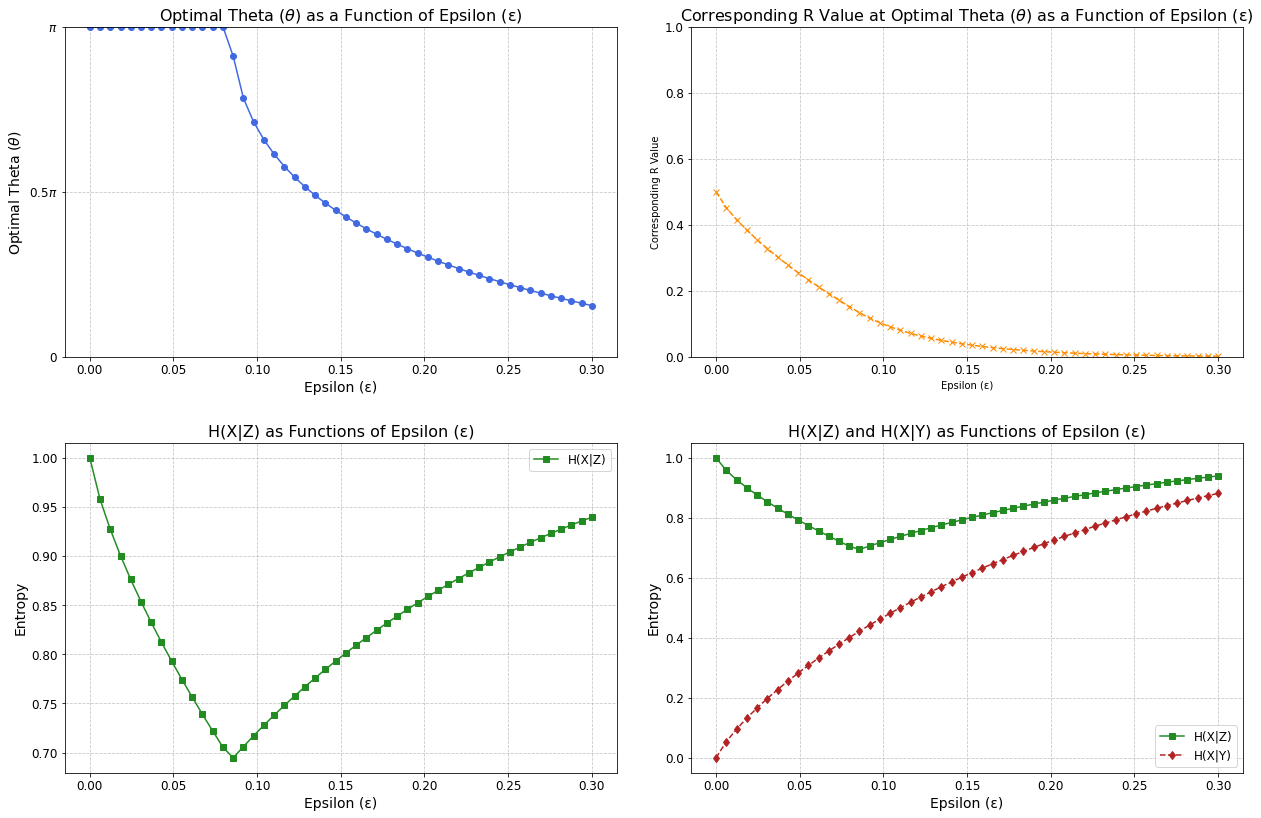

In [57]:
# Plot for analysis

eps_values = np.linspace(1e-6, 0.3, 50)
optimal_theta_values = []
optimal_R_values = []
h_XZ_values = []
h_XY_values = []

for eps_val in eps_values:
    opt_theta = find_optimal_theta(eps_val)
    optimal_theta_values.append(opt_theta)
    optimal_R_values.append(R_func(eps_val, opt_theta))
    h_XZ_values.append(h_XZ_func(eps_val,opt_theta))
    h_XY_values.append(-eps_val * np.log2(eps_val + 1e-10) - (1 - eps_val) * np.log2(1 - eps_val + 1e-10))

plt.figure(figsize=(18, 12)) 

# Plot for Optimal Theta
plt.subplot(2, 2, 1)
plt.plot(eps_values, optimal_theta_values, marker='o', linestyle='-', color='royalblue', markersize=6, linewidth=1.5)
plt.xlabel('Epsilon (ε)', fontsize=14)
plt.ylabel(r'Optimal Theta ($\theta$)', fontsize=14)
plt.title(r'Optimal Theta ($\theta$) as a Function of Epsilon (ε)', fontsize=16)
plt.ylim(0, np.pi)
plt.yticks([0, np.pi / 2, np.pi],
           [r'$0$', r'$0.5{\pi}$', r'$\pi$'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot for Corresponding R Values
plt.subplot(2, 2, 2) 
plt.plot(eps_values, optimal_R_values, marker='x', linestyle='--', color='darkorange', markersize=6, linewidth=1.5)
plt.xlabel('Epsilon (ε)')
plt.ylabel('Corresponding R Value')
plt.title(r'Corresponding R Value at Optimal Theta ($\theta$) as a Function of Epsilon (ε)', fontsize=16)
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot for H(X|Z)
plt.subplot(2, 2, 3)
plt.plot(eps_values, h_XZ_values, marker='s', linestyle='-', color='forestgreen', markersize=6, linewidth=1.5, label='H(X|Z)')
plt.xlabel('Epsilon (ε)', fontsize=14)
plt.ylabel('Entropy', fontsize=14)
plt.title('H(X|Z) as Functions of Epsilon (ε)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Plot for H(X|Y) and H(X|Z)
plt.subplot(2, 2, 4)
plt.plot(eps_values, h_XZ_values, marker='s', linestyle='-', color='forestgreen', markersize=6, linewidth=1.5, label='H(X|Z)')
plt.plot(eps_values, h_XY_values, marker='d', linestyle='--', color='firebrick', markersize=6, linewidth=1.5, label='H(X|Y)')
plt.xlabel('Epsilon (ε)', fontsize=14)
plt.ylabel('Entropy', fontsize=14)
plt.title('H(X|Z) and H(X|Y) as Functions of Epsilon (ε)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot
plt.tight_layout(pad=3.0)
plt.show()

Find upper bound of Eve's information gain I(X;Z)

In [60]:
# Find critical point of H(X|Z)

hxz_func = sp.lambdify((eps, theta), h_XZ, 'numpy')
d_hxz = sp.diff(h_XZ, eps)
d_hxz_func = sp.lambdify((eps, theta), d_hxz, 'numpy')

def H_XZ_gradient_descent(eps_start=0.080, learning_rate=0.001, max_iter=100, decay=0.99):
    eps_cur = eps_start

    optimal_theta = find_optimal_theta(eps_cur)
    H_XZ_cur = hxz_func(eps_cur, optimal_theta)

    for i in range(max_iter):
        optimal_theta = find_optimal_theta(eps_cur)
        gradient = d_hxz_func(eps_cur, optimal_theta)

        eps_next = eps_cur - learning_rate * gradient
        eps_next = max(0.08, min(eps_next, 0.09))

        optimal_theta_next = find_optimal_theta(eps_next)
        H_XZ_next = hxz_func(eps_next, optimal_theta_next)

        if H_XZ_next > H_XZ_cur:
            break

        eps_cur, H_XZ_cur = eps_next, H_XZ_next
        learning_rate *= decay

    return eps_cur, H_XZ_cur

eps_critical, hxz_critical = H_XZ_gradient_descent()
eps_critical, hxz_critical

(0.08527806509267262, 0.6938190524967137)

In [49]:
# Find upper bound on Eve's knowledge I(X;Z) = H(X) - H(X|Z)
i_hz = 1 - hxz_critical

print(f"Upper bound of Eve's knowledge: {i_hz}")

Upper bound of Eve's knowledge: 0.3061809475032863


Analyse Eve's Cloning Strategy

In [50]:
# Compare H(X|Z) and h(Fe)

# Define fidelity of Eve and the binary entropy h(Fe)
Fe = 0.5 * (1 + sp.cos(sp.asin(1 - 2 * eps)))
h_Fe = -Fe * sp.log(Fe, 2) - (1 - Fe) * sp.log(1 - Fe, 2)

# Substitute eps and corresponding optimal theta value
sh_xz = h_XZ.subs({eps: eps_val, theta: optimal_theta})
sh_Fe = h_Fe.subs({eps: eps_val})
sh_xz_value = sh_xz.evalf()
sh_Fe_value = sh_Fe.evalf()

print(f"H(X|Z): {sh_xz_value}")
print(f"h(Fe): {sh_Fe_value}")

H(X|Z): 0.373190382300968
h(Fe): 0.250224911611071


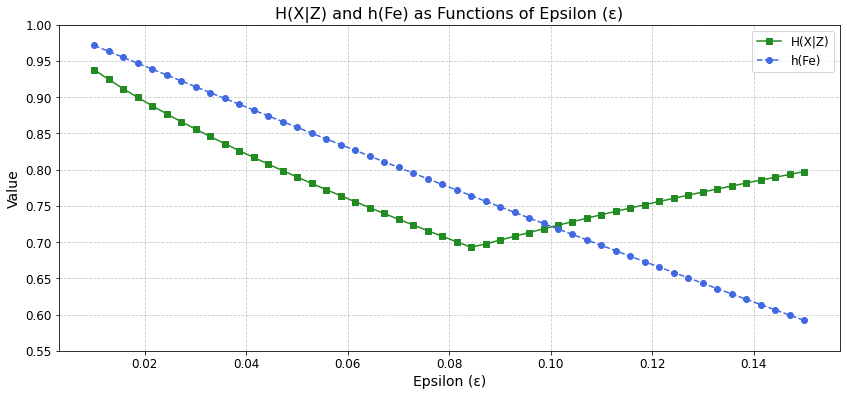

In [51]:
Fe_func = sp.lambdify(eps, Fe, 'numpy')
h_Fe_func = sp.lambdify(eps, h_Fe, 'numpy')

eps_values = np.linspace(0.01, 0.15, 50)
optimal_theta_values = []
optimal_R_values = []
h_values = []
Fe_values = []
h_Fe_values = []

for eps_val in eps_values:
    opt_theta = find_optimal_theta(eps_val)
    optimal_theta_values.append(opt_theta)
    optimal_R_values.append(R_func(eps_val, opt_theta))
    h_values.append(h_XZ_func(eps_val,opt_theta))
    Fe_values.append(Fe_func(eps_val))  # Compute Fe
    h_Fe_values.append(h_Fe_func(eps_val))  # Compute h(Fe)

# Plot for H(X|Z)
plt.figure(figsize=(14, 6)) 
plt.plot(eps_values, h_values, marker='s', linestyle='-', color='forestgreen', markersize=6, linewidth=1.5, label='H(X|Z)')
plt.plot(eps_values, h_Fe_values, marker='o', linestyle='--', color='royalblue', markersize=6, linewidth=1.5, label='h(Fe)')
plt.xlabel('Epsilon (ε)', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('H(X|Z) and h(Fe) as Functions of Epsilon (ε)', fontsize=16)
plt.ylim(0.55, 1)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout and display
plt.show()

In [52]:
# Find intersection where afterwards Eve's strategy becomes less effective

hxz_func = sp.lambdify((eps, theta), h_XZ, 'numpy')
hfe_func = sp.lambdify(eps, h_Fe, 'numpy')

def find_intersection(eps_start=0.10, learning_rate=0.0001, max_iter=1000, tol=1e-8, decay=0.99):
    eps_cur = eps_start
    prev_eps = None
    lr = learning_rate

    for i in range(max_iter):
        optimal_theta = find_optimal_theta(eps_cur)
        hxz_value = hxz_func(eps_cur, optimal_theta)
        hfe_value = hfe_func(eps_cur)
        diff = hxz_value - hfe_value

        gradient = d_hxz_func(eps_cur, optimal_theta)

        eps_next = eps_cur - lr * diff / gradient
        eps_next = max(0.09, min(eps_next, 0.11))

        # Check for convergence
        if prev_eps is not None and abs(eps_next - prev_eps) < tol:
            break

        prev_eps = eps_cur
        eps_cur = eps_next
        lr *= decay

    final_theta = find_optimal_theta(eps_cur)
    hxz_final = hxz_func(eps_cur, final_theta)
    hfe_final = hfe_func(eps_cur)
    diff_final = hxz_final - hfe_final

    return eps_cur, hxz_final, hfe_final, diff_final

eps_intersection, hxz_at_intersection, hfe_at_intersection, diff_at_intersection = find_intersection()

print(f"The intersection occurs at epsilon = {eps_intersection:.6f}")
print(f"H(X|Z) = {hxz_at_intersection:.6f} and h(Fe) = {hfe_at_intersection:.6f}")

The intersection occurs at epsilon = 0.099995
H(X|Z) = 0.720749 and h(Fe) = 0.721942


In [53]:
# The CM parameter critical point
eta = sp.asin(1 - 2 * eps_intersection) / np.pi

print(f"eta = {eta} pi")

eta = 0.295172881247183 pi


Save Results to csv File for Further Analysis

In [54]:
R_func = sp.lambdify((eps, theta), R, 'numpy')
eps_values = np.linspace(1e-8, 0.5 - 1e-8, 100)

optimal_theta_values = []
optimal_R_values = []
h_XZ_values = []
h_XY_values = []
h_Fe_values = []

for eps_val in eps_values:
    opt_theta = find_optimal_theta(eps_val)
    optimal_theta_values.append(opt_theta)
    optimal_R_values.append(R_func(eps_val, opt_theta))
    h_XZ_values.append(h_XZ_func(eps_val, opt_theta))
    h_XY_values.append(-eps_val * np.log2(eps_val + 1e-10) - (1 - eps_val) * np.log2(1 - eps_val + 1e-10))
    h_Fe_values.append(h_Fe_func(eps_val))

data = {
    "eps": eps_values,
    "optimal_theta": optimal_theta_values,
    "R": optimal_R_values,
    "h_XZ": h_XZ_values,
    "h_XY": h_XY_values,
    "h_Fe": h_Fe_values
}
df_results = pd.DataFrame(data)

# Save to CSV
current_directory = os.getcwd()
csv_path = os.path.join(current_directory, "collective_attack.csv")
df_results.to_csv(csv_path, index=False)